In [1]:
%load_ext autoreload
%autoreload 2
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
#    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
#    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
#    'FranoisTARANTIN': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
#    'GrenobleNvAir': 'Grenoble Nouvel Air',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',    
}

In [3]:
filename = 'data.csv'
if not os.path.isfile(filename):
    df = pandas.concat([tw.get_data(user, n=200, tag=tag) for user, tag in users.items()])
    df.to_csv(filename, index=False)
else:
    df = pandas.read_csv(filename)
    df['date'] = pandas.to_datetime(df['date'])
df = df[df['date'] >= pandas.to_datetime('2019-09-01')]
print(len(df), len(df.columns))

805 10


In [4]:
df.sample(n=10)

,name,login,likes,retweets,text,date,in_reply,source,coordinates,geo
782,Alain Carignon,CarignonAlain,23,3,🎈Rentrée des classes à Elysée Chatin. Toujours...,2019-09-02 09:06:30,NaN,Twitter for iPhone,NaN,NaN
51,Éric Piolle,EricPiolle,59,23,"👫🌳 Egalité, bio, fraicheur, solidarité, cours ...",2019-12-11 07:27:53,NaN,Twitter Web App,NaN,NaN
144,Éric Piolle,EricPiolle,26,5,"🏃‍♀️10e course sportive et solidaire ""LA GRENO...",2019-09-22 08:19:33,NaN,Twitter Web App,NaN,NaN
255,Emilie CHALAS,EmilieCChalas,5,1,Bilan du marché immobilier d’entreprise 2019 p...,2020-01-23 13:43:42,NaN,Twitter for iPhone,NaN,NaN
745,Alain Carignon,CarignonAlain,21,6,🔴 Extrait de l’interview de @JJBourdin_RMC @RM...,2019-09-23 13:06:28,NaN,TweetDeck,NaN,NaN
769,Alain Carignon,CarignonAlain,12,5,😂 Eclat de rire avec le chorégraphe Jean-Claud...,2019-09-15 13:12:28,NaN,Twitter for iPhone,NaN,NaN
0,Éric Piolle,EricPiolle,11,1,A tout de suite sur @f3Alpes https://t.co/r1dO...,2020-02-18 18:05:51,NaN,Twitter for Android,NaN,NaN
266,Emilie CHALAS,EmilieCChalas,42,14,"Invasion violente à la #CFDT, appel à agressio...",2020-01-18 18:39:58,NaN,Twitter for iPhone,NaN,NaN
471,Emilie CHALAS,EmilieCChalas,6,1,Grenelle contre les #ViolencesConjugales : \n👉...,2019-10-15 15:13:05,NaN,Twitter for iPhone,NaN,NaN
348,Emilie CHALAS,EmilieCChalas,248,65,Je serai au rdv des Municipales de mars 2020. ...,2019-12-07 18:37:17,NaN,Twitter for iPhone,NaN,NaN


/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 16 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/figure.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


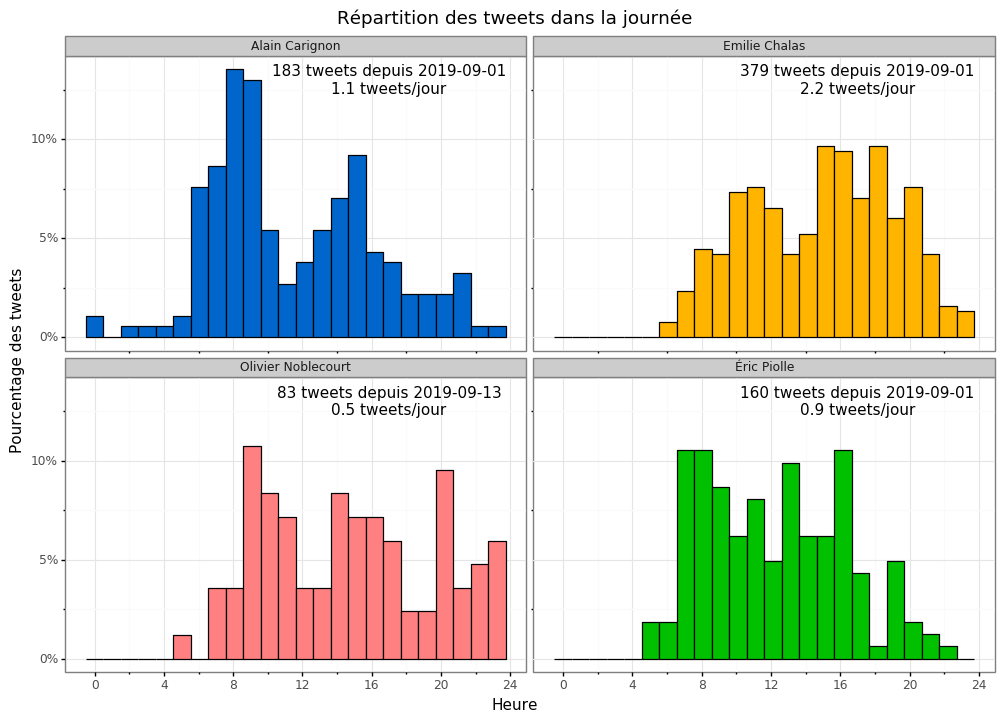

<ggplot: (-9223363256425795324)>

In [5]:
from mizani.formatters import percent_format

def format_text(row):
    return f'{row["count"]} tweets depuis {row["min"]}\n{row["intensity"]:.1f} tweets/jour'

def format_name(row):  # some candidates write their names in all-caps...
    names = row['name'].lower().split()
    names = [f'{n[0].upper()}{n[1:]}' for n in names]
    return ' '.join(names)

df['tag'] = df.apply(lambda row: users[row['login']], axis=1)
df['name'] = df.apply(format_name, axis=1)

tmp = df.groupby('name')[['date']].agg(['min', 'max', 'count']).reset_index(col_level=1)
tmp.columns = tmp.columns.droplevel()
tmp['intensity'] = tmp['count'] / (tmp['max'] - tmp['min']).dt.days
tmp['min'] = tmp['min'].dt.date
tmp['max'] = tmp['max'].dt.date
tmp['text'] = tmp.apply(format_text, axis=1)
tmp

df['time'] = pandas.to_timedelta(df['date'].dt.time.astype(str)).dt.total_seconds() / 3600  # some dirty hack
plot = ggplot(df) +\
    geom_histogram(aes(x='time', fill='tag', y='..density..'), color='black', bins=24) +\
    theme_bw() +\
    scale_fill_manual(colors) +\
    xlab('Heure') +\
    ylab('Pourcentage des tweets') +\
    labs(fill='Mouvement') +\
    facet_wrap('name') +\
    theme(legend_position='none') +\
    scale_x_continuous(breaks=range(0, 25, 4)) +\
    scale_y_continuous(labels = percent_format()) +\
    geom_text(tmp, aes(label='text'), x=17, y=0.13) +\
    ggtitle('Répartition des tweets dans la journée')

plot.save('/tmp/figure.png', width=16, height=10)

plot

In [6]:
df.groupby('name')[['date']].agg(['min', 'count'])

date      
                                   min count
name                                        
Alain Carignon     2019-09-01 15:13:10   183
Emilie Chalas      2019-09-01 15:41:58   379
Olivier Noblecourt 2019-09-13 07:52:23    83
Éric Piolle        2019-09-01 06:54:52   160

In [7]:
df.groupby(['name', 'source'])[['date']].count()

date
name               source                   
Alain Carignon     TweetDeck               6
                   Twitter Web App        28
                   Twitter for iPhone    149
Emilie Chalas      Twitter Web App        16
                   Twitter for iPhone    363
Olivier Noblecourt Twitter Web App         4
                   Twitter Web Client      5
                   Twitter for Android    11
                   Twitter for Mac         3
                   Twitter for iPad       15
                   Twitter for iPhone     45
Éric Piolle        Twitter Web App        64
                   Twitter for Android    96

In [8]:
tmp = tw.get_mentions(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name               mention               
Emilie Chalas      @EricPiolle         23
Olivier Noblecourt @GrenobleNvAir      21
Alain Carignon     @EricPiolle         17
Emilie Chalas      @AN_ComLois         15
                   @AssembleeNat       15
Alain Carignon     @teleGrenoble       14
Emilie Chalas      @MarleneSchiappa    13
                   @VilledeGrenoble    12
                   @gouvernementFR     11
Alain Carignon     @JJBourdin_RMC      11
Emilie Chalas      @OlgaGivernet        9
                   @m_chamussy          8
                   @bleu_isere          7
Alain Carignon     @ledauphine          7
Emilie Chalas      @LeDL_Grenoble       7
                   @f3Alpes             7
                   @barbarapompili      7
Éric Piolle        @FestivalDuLivre     6
Emilie Chalas      @LaREM_AN            6
Éric Piolle        @editionsLLL         6

In [9]:
tmp = tw.get_hashtags(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name               mention                            
Emilie Chalas      #Grenoble                       155
Alain Carignon     #Grenoble                       125
                   #Carignon2020                    96
                   #SocieteCivile                   49
Emilie Chalas      #Municipales2020                 35
                   #UnNouveauRegardSurGrenoble      23
Olivier Noblecourt #Strat                           18
                   #Grenoble                        18
Alain Carignon     #SocieteCivilePourlAlternance    10
Emilie Chalas      #TransitionEcologique             9
                   #DimPol                           9
                   #CMGrenoble                       8
                   #grenoble                         8
                   #GrenelleViolencesConjugales      8
Alain Carignon     #grenoble                         8
Emilie Chalas      #MatinaleBleuIsere                6
                   #VilleNature                      6
                   #FonctionPublique                 6
                   #ViolencesConjugales              6
                   #ChalasDirect                     6

In [10]:
tw.count_patterns(df, ['climat', 'dette', 'corruption', 'corrompu', 'retraite', 'arbre'])

,name,login,tweet,pattern
3,Éric Piolle,EricPiolle,36,climat
0,Emilie Chalas,EmilieCChalas,9,retraite
1,Éric Piolle,EricPiolle,4,arbre
0,Emilie Chalas,EmilieCChalas,4,arbre
1,Éric Piolle,EricPiolle,2,retraite
2,Olivier Noblecourt,onoblecourt,2,climat
1,Emilie Chalas,EmilieCChalas,2,climat
1,Emilie Chalas,EmilieCChalas,2,dette
0,Alain Carignon,CarignonAlain,2,climat
0,Alain Carignon,CarignonAlain,2,dette


In [11]:
tw.count_patterns(df, ['piolle', 'carignon', 'chalas', 'noblecourt'])

,name,login,tweet,pattern
0,Alain Carignon,CarignonAlain,96,carignon
1,Emilie Chalas,EmilieCChalas,31,piolle
0,Alain Carignon,CarignonAlain,17,piolle
1,Emilie Chalas,EmilieCChalas,7,carignon
0,Emilie Chalas,EmilieCChalas,7,chalas
1,Olivier Noblecourt,onoblecourt,5,noblecourt
0,Emilie Chalas,EmilieCChalas,5,noblecourt
2,Olivier Noblecourt,onoblecourt,4,piolle
1,Olivier Noblecourt,onoblecourt,2,chalas
2,Olivier Noblecourt,onoblecourt,1,carignon


/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 16 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/figure.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


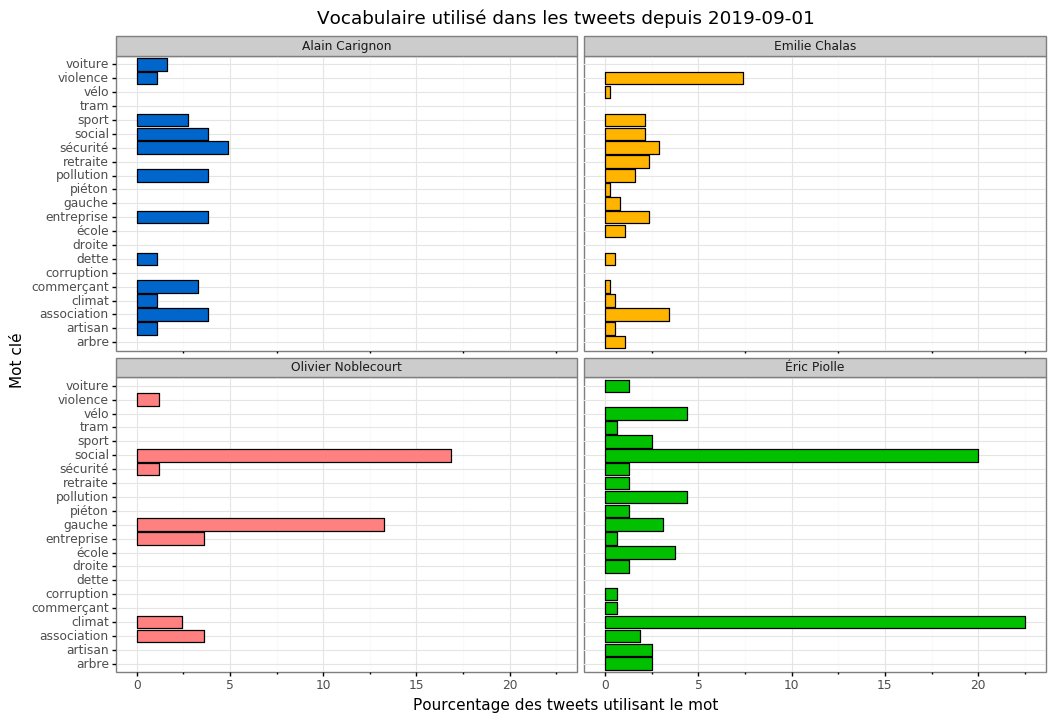

<ggplot: (-9223363256428629388)>

In [12]:
keywords = [
    'arbre',
    'artisan',
    'association',
    'climat',
    'commerçant',
    'corruption',
    'dette',
    'droite',
    'école',
    'entreprise',
    'gauche',
    'piéton',
    'pollution',
    'retraite',
    'sécurité',
    'social',
    'sport',
    'tram',
    'vélo',
    'violence',
    'voiture',
]

def get_keywords(df, keywords):
    tmp = tw.count_patterns(df, keywords)
    tmp['tag'] = tmp.apply(lambda row: users[row['login']], axis=1)
    nb_tweets = df.groupby('login')[['name']].count().reset_index()
    nb_tweets.columns = ['login', 'count']
    tmp = tmp.set_index('login').join(nb_tweets.set_index('login'))
    tmp['percent'] = tmp['tweet'] / tmp['count'] * 100
    assert set(tmp.pattern.unique()) == set(keywords)  # will raise an error if one keyword is not used at all
    return tmp

def plot_keywords(df, keywords):
    tmp = get_keywords(df, keywords)
    min_date = df['date'].min().date()
    plot = ggplot(tmp) +\
        geom_bar(aes(x='pattern', y='percent', fill='tag'), stat='identity', color='black', position='dodge') +\
        theme_bw() +\
        scale_fill_manual(colors) +\
        xlab('Mot clé') +\
        ylab('Pourcentage des tweets utilisant le mot') +\
        labs(fill='Mouvement') +\
        facet_wrap('name') +\
        theme(legend_position='none') +\
        ggtitle(f'Vocabulaire utilisé dans les tweets depuis {min_date}') +\
        scale_x_discrete(limits=keywords) +\
        coord_flip()

    plot.save('/tmp/figure.png', width=16, height=10)

    return plot

plot_keywords(df, keywords)